In [1]:
import sys,os
import pickle
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scanpy as sc
from IPython.display import Image
import skimage.io

In [2]:
data_dir = '/lustre/scratch117/cellgen/team283/Kidney-Nanostring/'
analysis_name = 'LocationModelWTAMultiExperimentHierarchicalGeneLevel_7experiments_33clusters_231locations_9551genes_narrow_sensitivity'
adata_wta = sc.read_h5ad(f'{data_dir}results/{analysis_name}/sp.h5ad')

# add coordinates
adata_wta.obsm['spatial'] = adata_wta.obs[['ROICoordinateX', 'ROICoordinateY']].values

spatialDecon_results1 = pd.read_csv(f'{data_dir}spatialDecon_results1.txt', sep='\t')

from re import sub
spatialDecon_results1.index == [sub('\\|','.', sub(' ','.', i)) for i in adata_wta.obs['SegmentDisplayName']]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [3]:
spatialDecon_results1.columns == [sub('-','.', sub('/','.', sub('\\|','.', sub(' ','.', i)))) for i in adata_wta.uns['mod']['fact_names']]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [4]:
spatialDecon_results1.columns = adata_wta.uns['mod']['fact_names']

In [5]:
# defining useful function
def select_slide(adata, s, s_col='SlideName'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [6]:
adata_wta.obs['SlideName'].value_counts()

disease3     59
normal3      55
disease1B    24
disease2B    24
disease4     24
normal4      23
normal2B     22
Name: SlideName, dtype: int64

In [7]:
adata_wta

AnnData object with n_obs × n_vars = 231 × 18503
    obs: 'SlideName', 'ScanName', 'ROILabel', 'SegmentLabel', 'SegmentDisplayName', 'Sample_ID', 'AOISurfaceArea', 'AOINucleiCount', 'ROICoordinateX', 'ROICoordinateY', 'RawReads', 'TrimmedReads', 'StitchedReads', 'AlignedReads', 'DeduplicatedReads', 'SequencingSaturation', 'UMIQ30', 'RTSQ30', 'disease_status', 'pathology', 'region', 'LOQ', 'NormalizationFactor', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'mean_spot_factorsAscending vasa recta endothelium', 'mean_spot_factorsB cell', 'mean_spot_factorsCD4 T cell', 'mean_spot_factorsCD8 T cell', 'mean_spot_factorsConnecting tubule', 'mean_spot_factorsDescending vasa recta endothelium', 'mean_spot_factorsDistinct proximal tubule 1', 'mean_spot_factorsDistinct proximal tubule 2', 'mean_spot_factorsEpithelial progenitor cell', 'mean_spot_factorsFibroblast', 'mean_spot_factorsGlomerular endothelium', 'mean_spot_factorsIndistinct intercalated cell', 'mean_spot_f

In [8]:
adata_wta.obs['AOISurfaceArea']

0       22152.10924
1       71817.92407
2       37316.69780
3      102112.72680
4       18398.68515
           ...     
226     34871.37949
227     29638.49826
228     24203.53455
229     24850.07060
230     22985.60386
Name: AOISurfaceArea, Length: 231, dtype: float64

In [9]:
del adata_wta.uns['mod']

In [10]:
adata_wta.obs[spatialDecon_results1.columns] = spatialDecon_results1.values

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


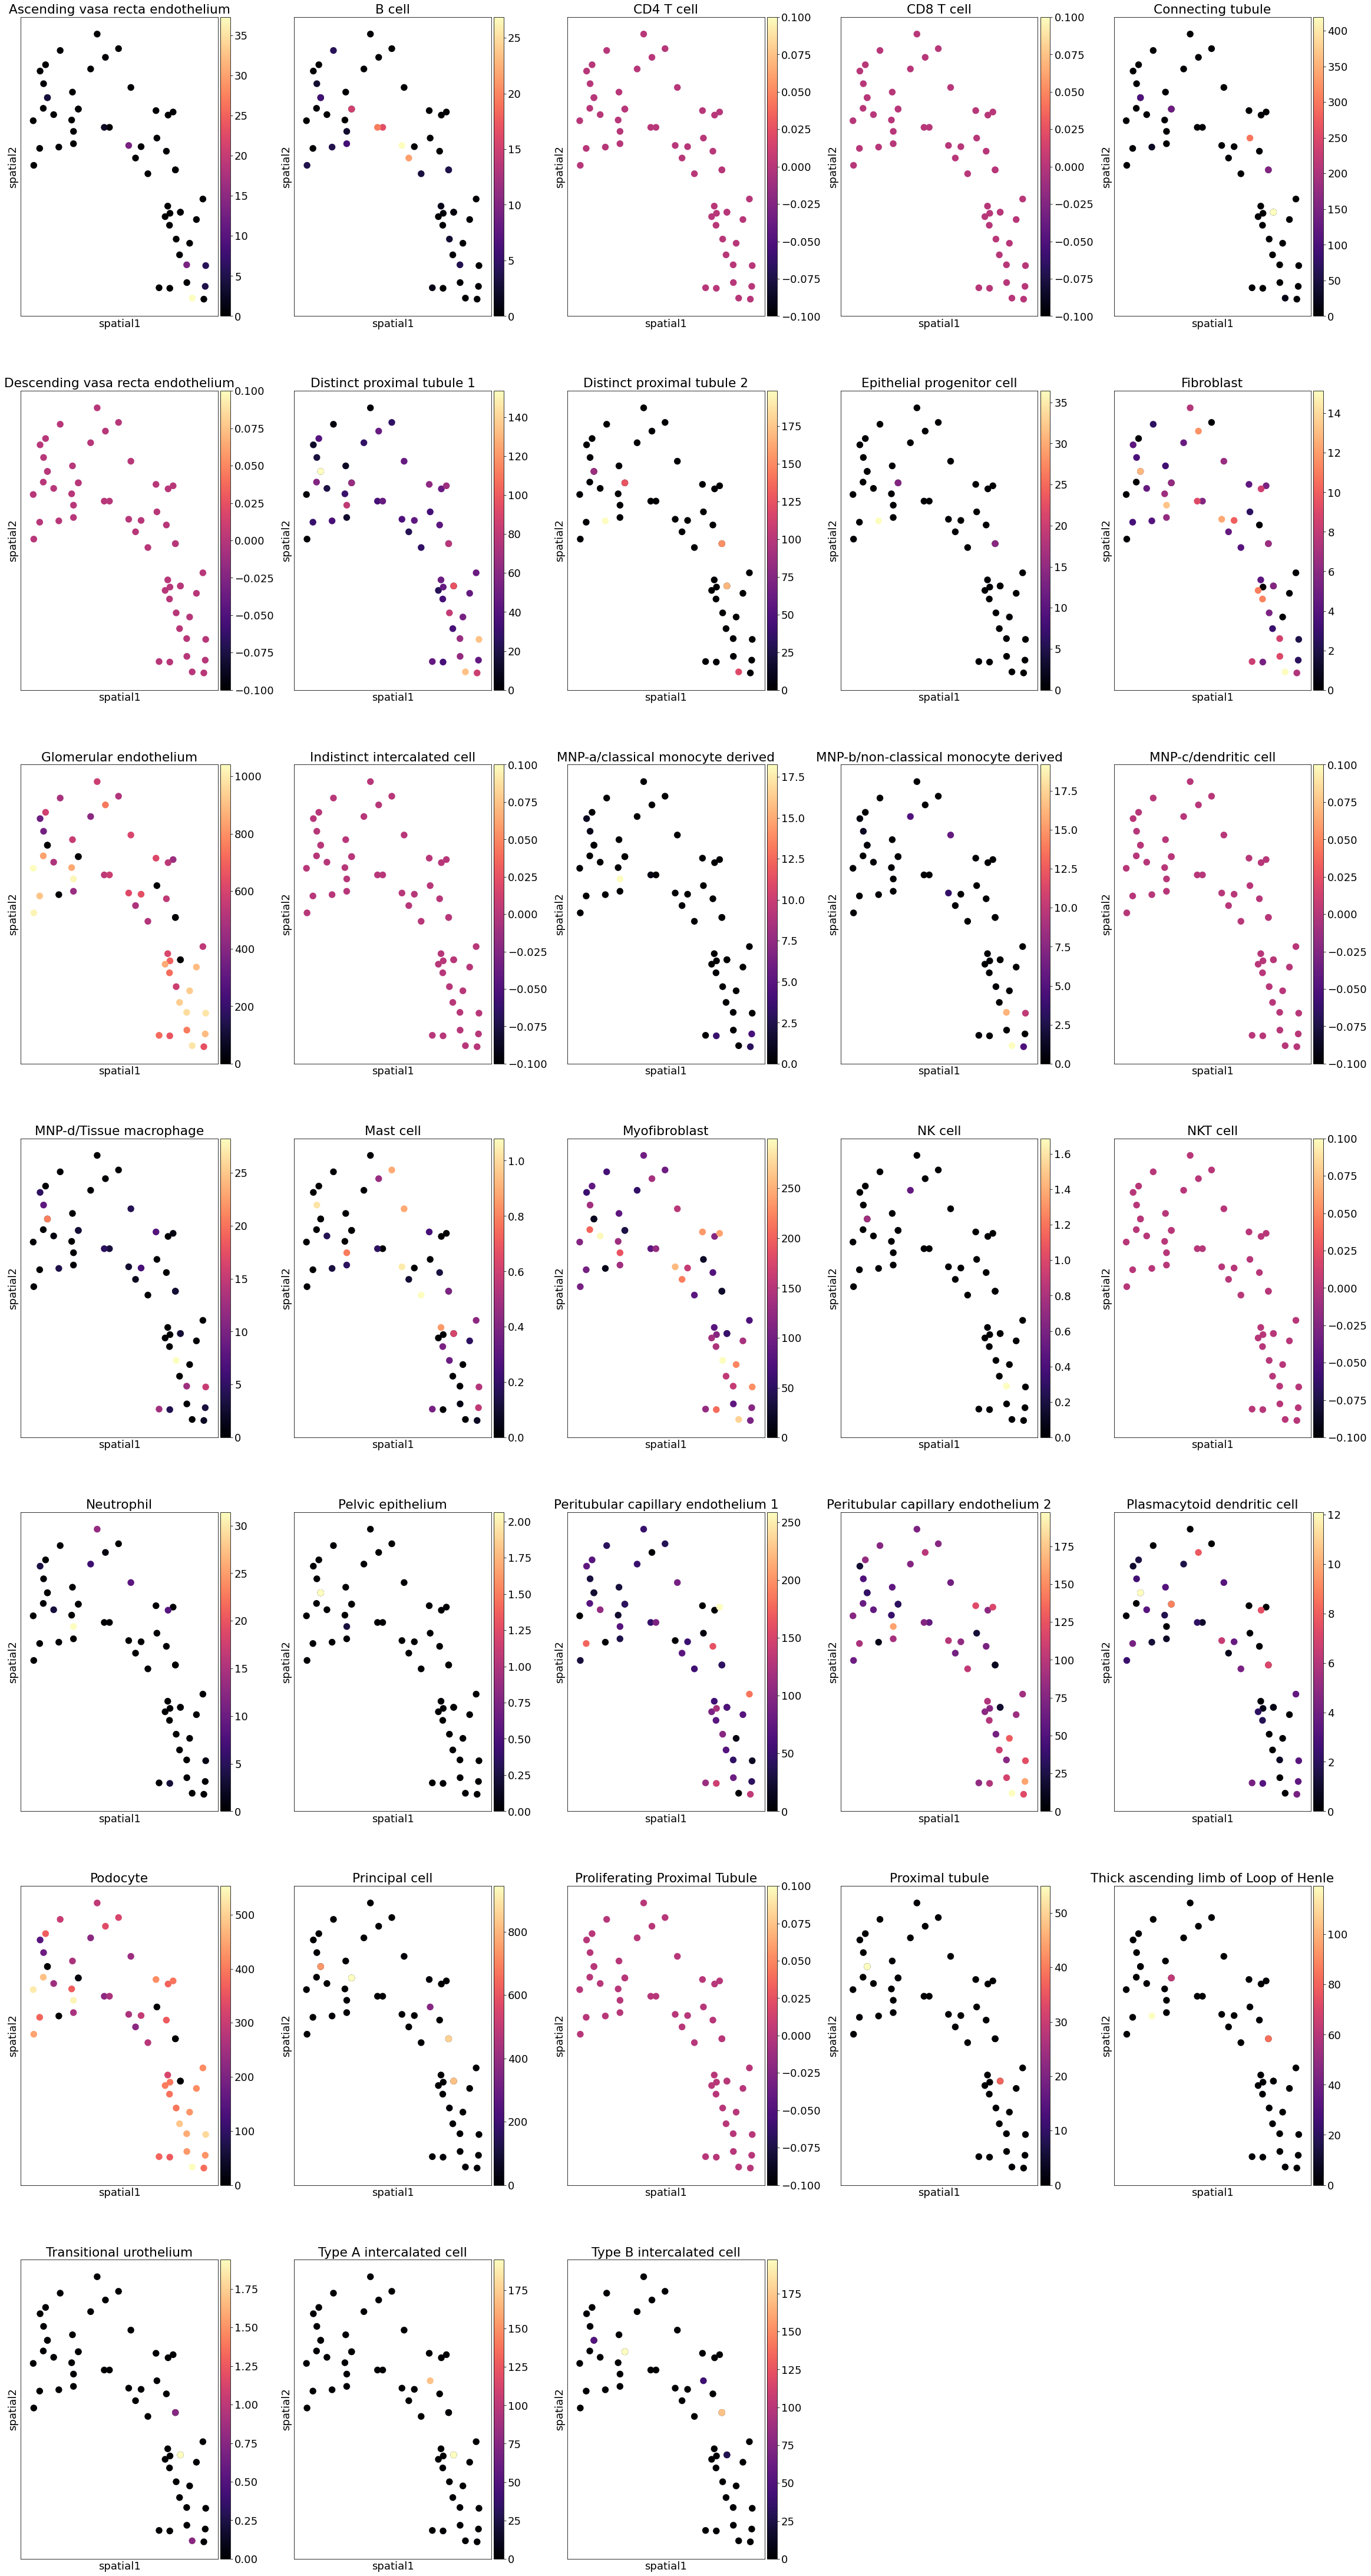

In [11]:
sel_clust = spatialDecon_results1.columns
sel_clust_col = ['' + str(i) for i in sel_clust]

# select one section correctly subsetting histology image data
#slide = select_slide(adata_wta, 'normal3', s_col='SlideName')
slide = adata_wta[adata_wta.obs['SlideName'] == 'normal3',:].copy()

# plot with nice names
with mpl.rc_context({'figure.figsize': (7, 10), "font.size": 18}):
    # add slide.obs with nice names
    slide.obs[sel_clust] = (slide.obs[sel_clust_col].T / (slide.obs['AOISurfaceArea'] / (10**6))).T

    sc.pl.spatial(slide, cmap='magma',
                  color=sel_clust, # limit size in this notebook
                  ncols=5,
                  spot_size=1000, img_key=None,
                  #alpha_img=0.9,
                  vmin=0, vmax='p99.2'
                 )

In [12]:
sel_clust = spatialDecon_results1.columns
sel_clust_col = ['' + str(i) for i in sel_clust]
sel_clust_new = ['cell_density_per_mm2_' + str(i) for i in sel_clust]

adata_wta.obs[sel_clust_new] = (adata_wta.obs[sel_clust_col].T / (adata_wta.obs['AOISurfaceArea'] / (10**6))).T

In [13]:
adata_wta.obs[sel_clust_new].to_csv(f'{data_dir}/spatialDecon_results1/cell_density_per_mm2.csv')
f'{data_dir}/spatialDecon_results1/cell_density_per_mm2.csv'

'/lustre/scratch117/cellgen/team283/Kidney-Nanostring//spatialDecon_results1/cell_density_per_mm2.csv'

In [14]:
def plot_spatial_per_cell_type(adata, 
                               cell_type=spatialDecon_results1.columns,
                               samples=adata_wta.obs['SlideName'].unique(),
                              ncol=4):
    n_samples = len(samples)
    nrow = int(np.ceil(n_samples / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(28, 6))
    if nrow == 1:
        axs = axs.reshape((1, ncol))
    
    col_name = f'cell_density_per_mm2_{cell_type}'
    vmax = np.quantile(adata.obs[col_name].values, 0.992)
    adata.obs[cell_type] = adata.obs[col_name].copy()
    
    from itertools import chain
    ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
    
    for i, s in enumerate(samples):
        #sp_data_s = select_slide(adata, s, s_col='SlideName')
        sp_data_s = adata[adata.obs['SlideName'] == s,:].copy()
        sc.pl.spatial(sp_data_s, cmap='magma',
                      color=cell_type, 
                      spot_size=1000, img_key=None,
                      vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False
                                            )
        axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)
    
    if len(samples) < len(axs.flatten()):
        for i in range(len(samples), len(axs.flatten())):
            axs[ind[i][0],ind[i][1]].axis('off')
    
    fig.tight_layout(pad=0.5)
        
    return fig


In [15]:
for c in spatialDecon_results1.columns:
    fig = plot_spatial_per_cell_type(adata_wta, cell_type=c)
    from re import sub
    c = sub(' ', '_', c)
    c = sub('/', '_', c)
    fig.savefig(f"{data_dir}/spatialDecon_results1/per_cell_type/W_cell_density_per_mm2_{c}.png",
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)

f"{data_dir}/spatialDecon_results1/per_cell_type/"

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


'/lustre/scratch117/cellgen/team283/Kidney-Nanostring//spatialDecon_results1/per_cell_type/'

## Plot violins/boxplots plot per condition

In [16]:
adata_wta.obs['region_original'] = adata_wta.obs['region'].copy()

adata_wta.obs['pathology_aux'] = adata_wta.obs['pathology'].astype(str).copy()
adata_wta.obs.loc[adata_wta.obs['region_original'] != 'glomerulus', 'pathology_aux'] = ''

adata_wta.obs['SegmentLabel_aux'] = adata_wta.obs['SegmentLabel'].astype(str).copy()
adata_wta.obs.loc[adata_wta.obs['region_original'] == 'glomerulus', 'SegmentLabel_aux'] = ''

adata_wta.obs['region'] = adata_wta.obs['region'].astype(str) \
+ '_'+ adata_wta.obs['SegmentLabel_aux'].astype(str) + adata_wta.obs['pathology_aux'].astype(str)
print(adata_wta.obs[['disease_status', 'pathology', 'region']].value_counts())

disease_status  pathology  region             
DKD             abnormal   glomerulus_abnormal    65
normal          healthy    glomerulus_healthy     54
DKD             nan        tubule_PanCK           24
                           tubule_neg             24
                healthy    glomerulus_healthy     18
normal          nan        tubule_PanCK           17
                           tubule_neg             17
                abnormal   glomerulus_abnormal    12
dtype: int64


In [17]:
def plot_violins(obs=adata_wta.obs, plot_type='violin',
                 cell_types=spatialDecon_results1.columns,
                 x="region", hue="disease_status", ncol=6):
    n_cell_types = len(cell_types)
    nrow = int(np.ceil(n_cell_types / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(5 * ncol, 5 * nrow))
    if nrow == 1:
        axs = axs.reshape((1, ncol))
        
    from itertools import chain
    ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
    
    for i, cell_type in enumerate(cell_types):
        col_name = f'cell_density_per_mm2_{cell_type}'
        
        if plot_type=='violin':
            sns.violinplot(data=adata_wta.obs, x=x, y=col_name, hue=hue,
                        split=True, inner="quart", 
                        linewidth=1,
                        palette={"normal": ".5", "DKD": ".85"},
                        ax=axs[ind[i][0],ind[i][1]])
            axs[ind[i][0],ind[i][1]].set_ylim(0);
            #sns.swarmplot(data=adata_wta.obs, x=x, y=col_name, hue=hue,
            #              palette={"normal": ".0", "DKD": ".0"}, 
            #              dodge=True, size=3,
            #              ax=axs[ind[i][0],ind[i][1]])
            
        if plot_type=='boxplot':
            sns.boxplot(data=adata_wta.obs, x=x, y=col_name, hue=hue,
                        linewidth=1,
                        palette={"normal": ".5", "DKD": ".85"},
                        ax=axs[ind[i][0],ind[i][1]])
            #sns.swarmplot(data=adata_wta.obs, x=x, y=col_name, hue=hue,
            #              palette={"normal": ".0", "DKD": ".0"}, 
            #              dodge=True, size=3,
            #              ax=axs[ind[i][0],ind[i][1]])
            
        sns.despine(left=True);

        axs[ind[i][0],ind[i][1]].title.set_text(cell_type)
    
    if len(cell_types) < len(axs.flatten()):
        for i in range(len(cell_types), len(axs.flatten())):
            axs[ind[i][0],ind[i][1]].axis('off')
    
    fig.tight_layout(pad=0.5)
        
    return fig


In [18]:
adata_wta.obs[f"cell_density_per_mm2_{spatialDecon_results1.columns[0]}"].min()

0.0

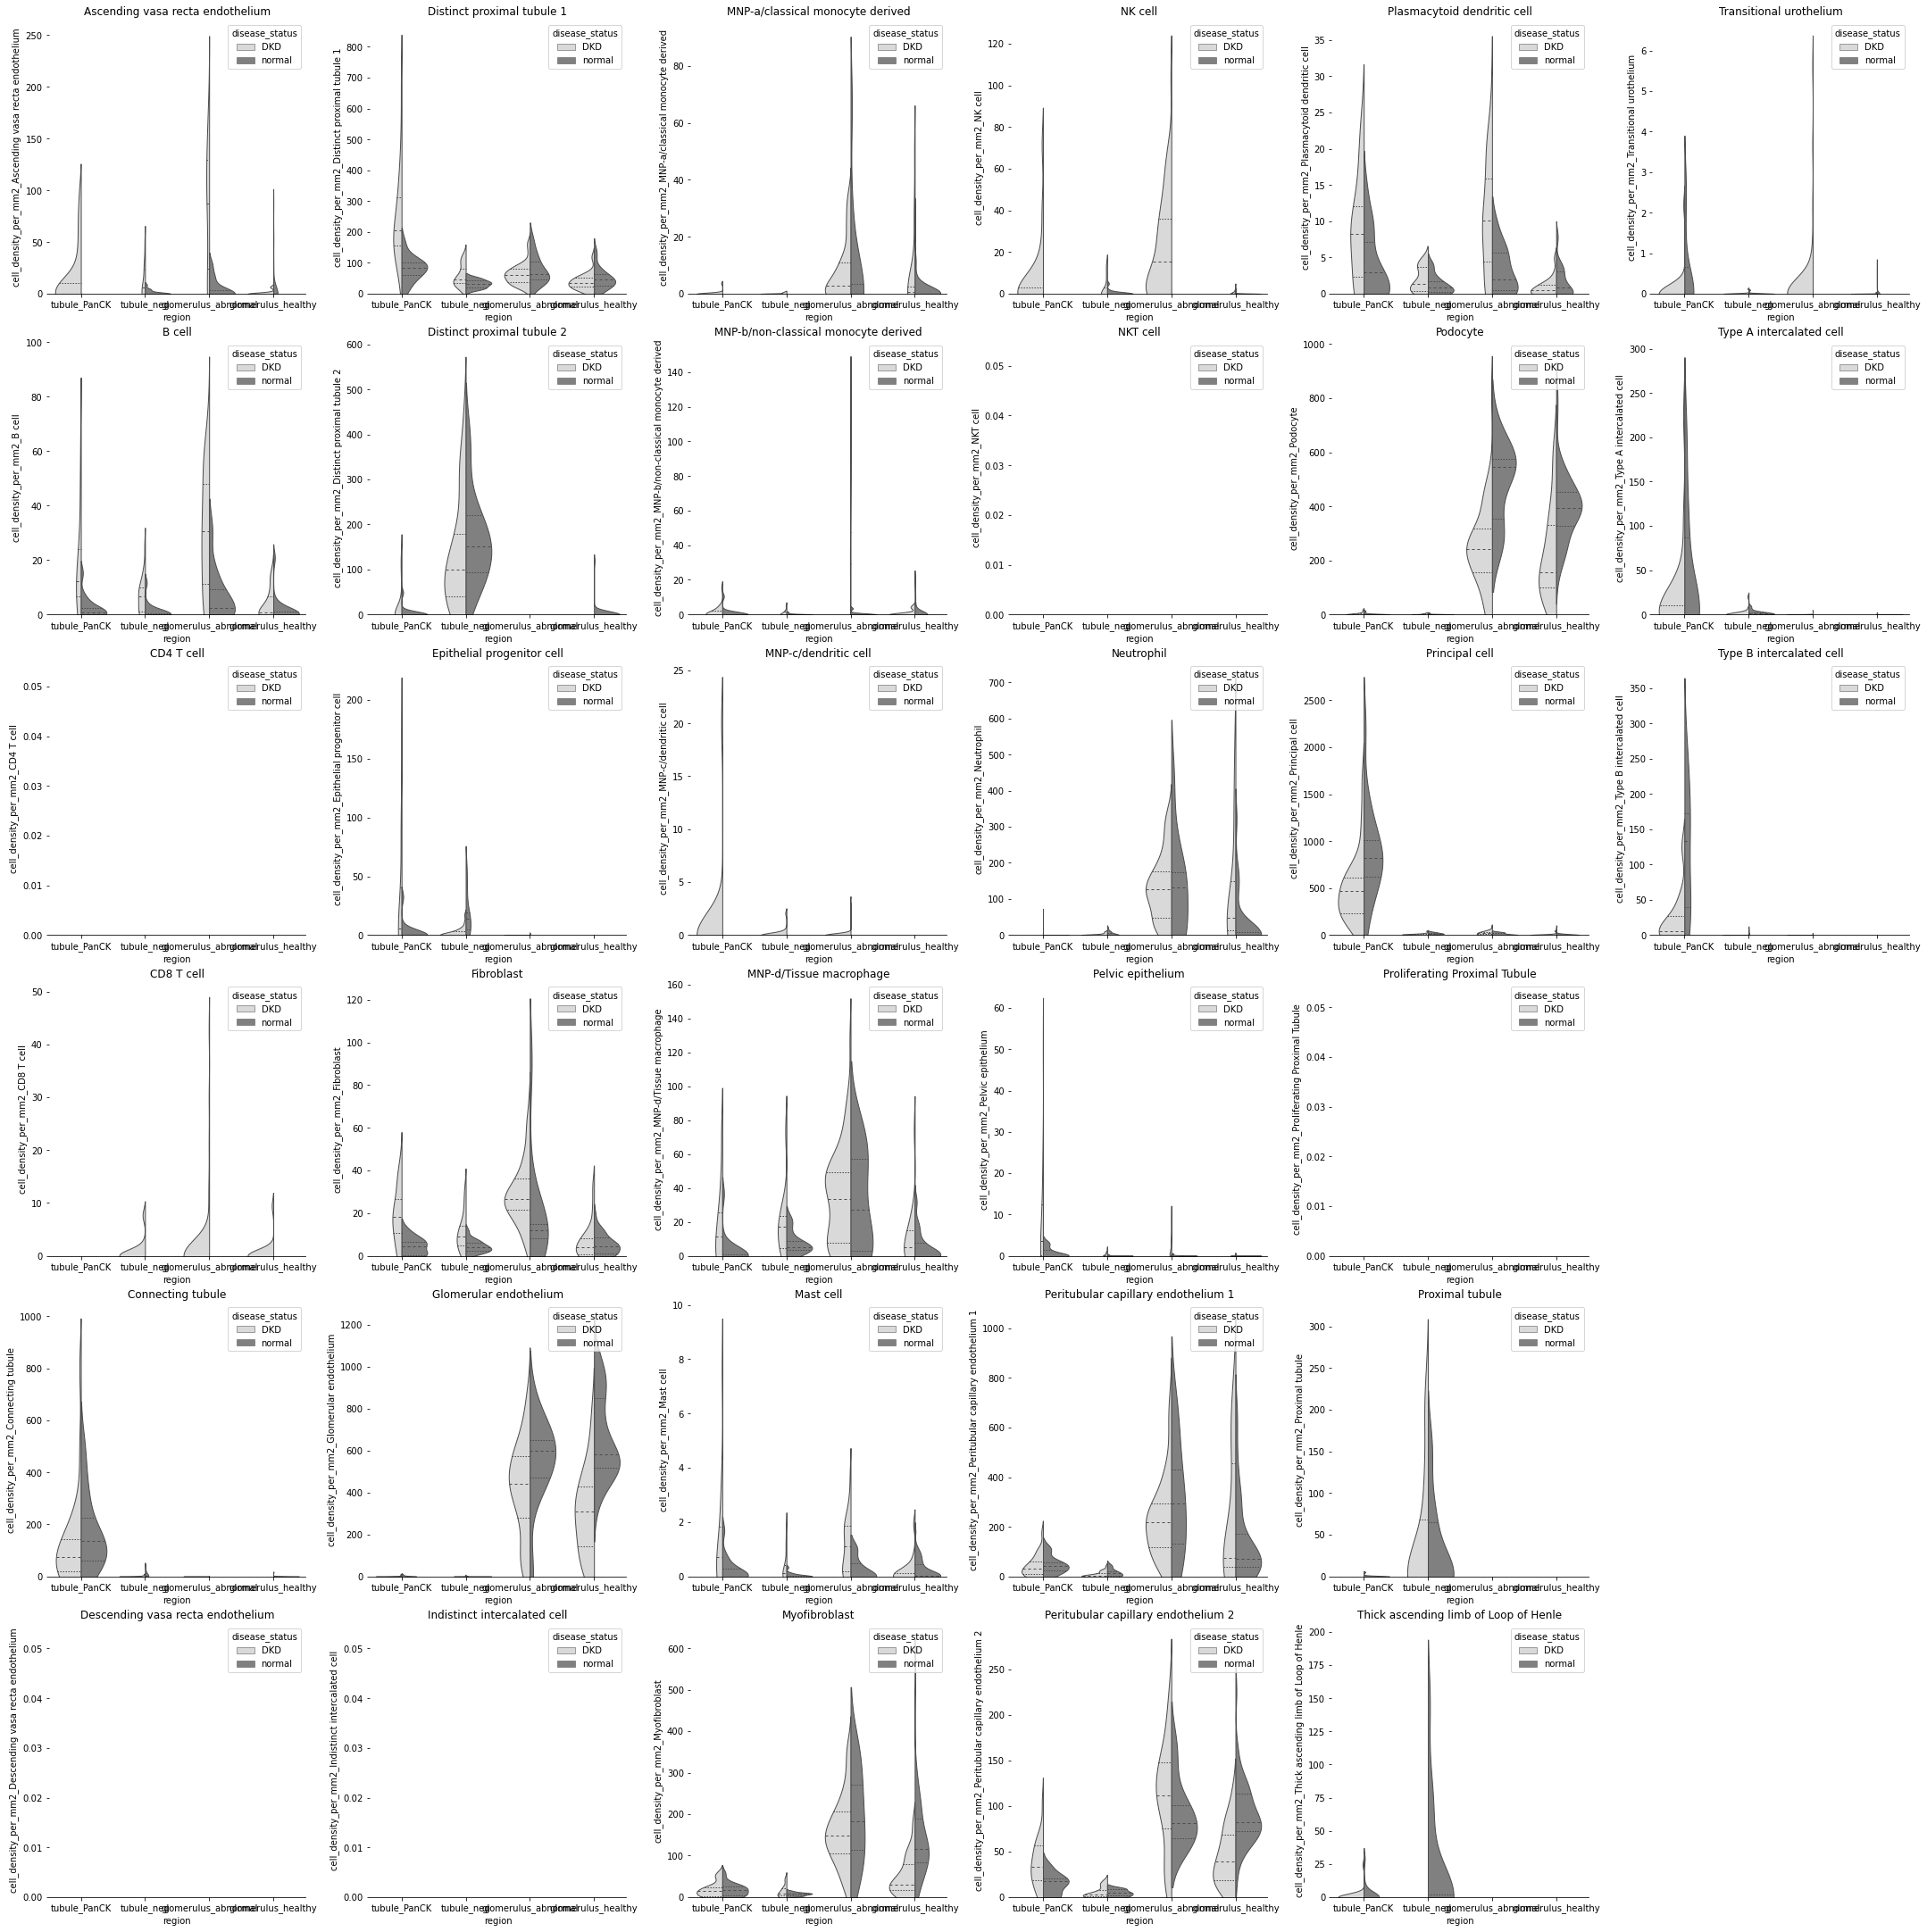

In [19]:
plot_violins(obs=adata_wta.obs, 
                 cell_types=spatialDecon_results1.columns,
                 x="region", hue="disease_status", ncol=6);

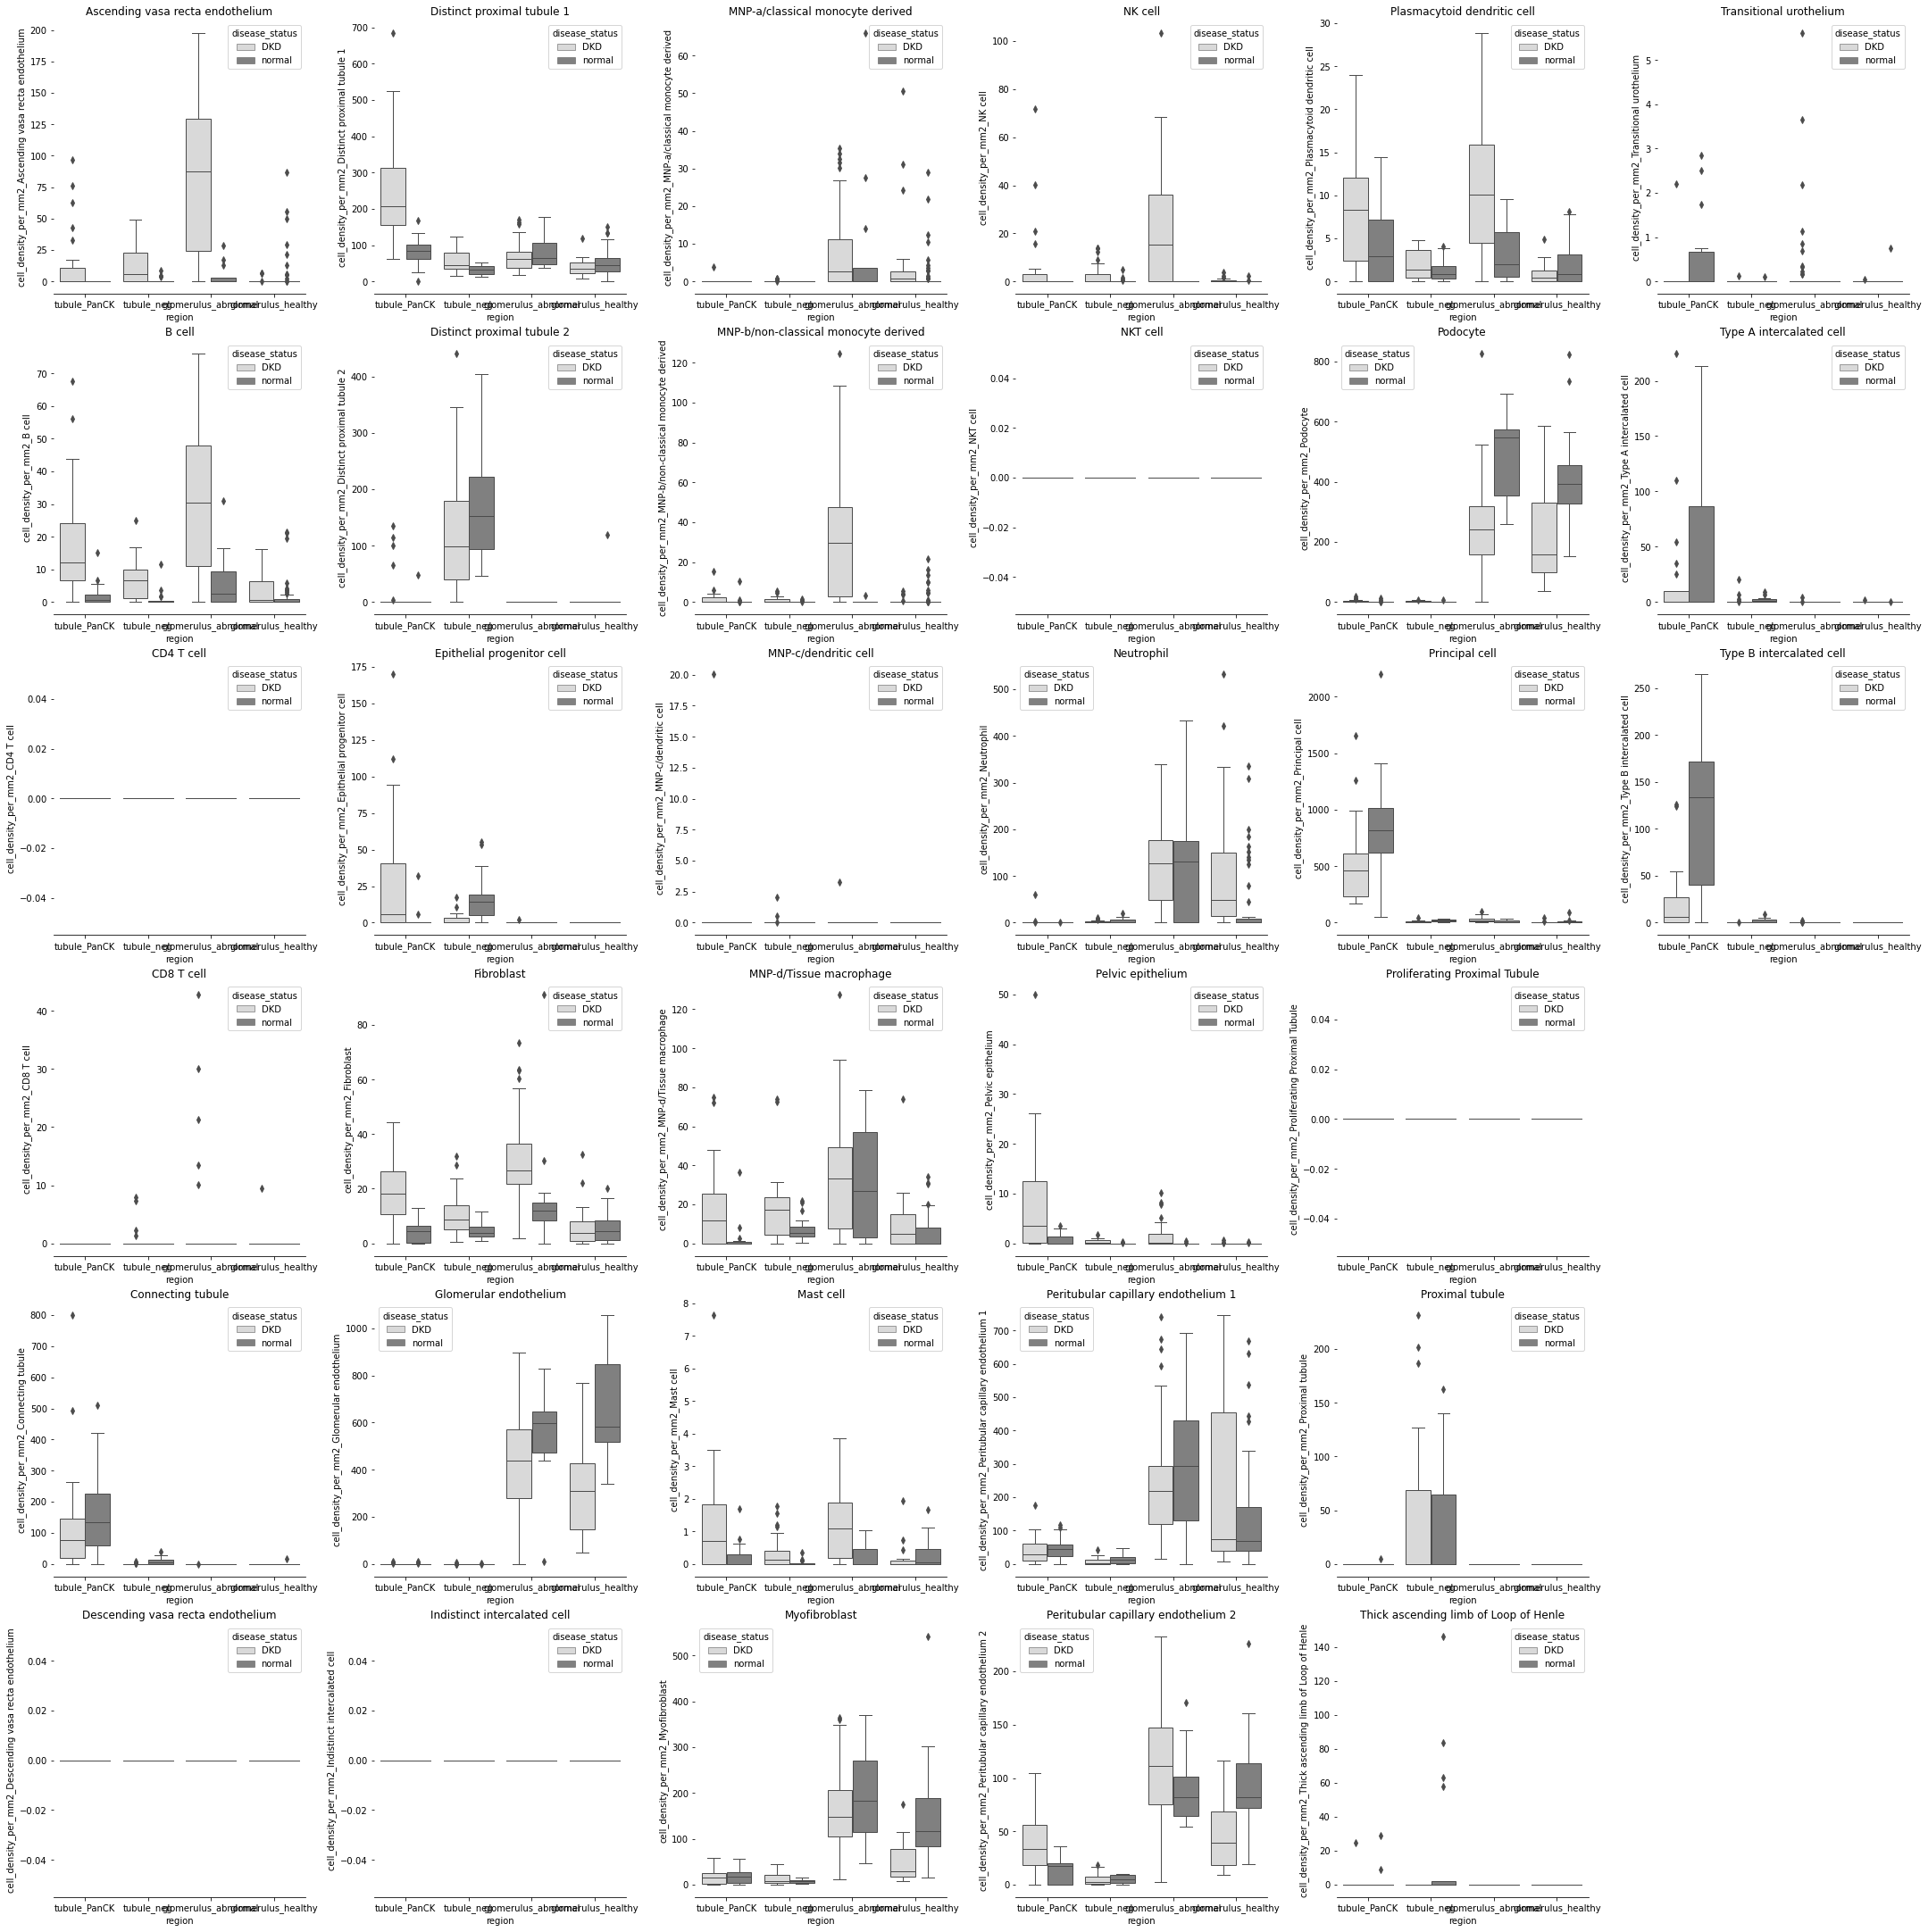

In [20]:
plot_violins(obs=adata_wta.obs, plot_type='boxplot',
                 cell_types=spatialDecon_results1.columns,
                 x="region", hue="disease_status", ncol=6);

In [21]:
id_vars = ['SegmentDisplayName', 'SlideName', 'disease_status', 'region']
obs_covar = adata_wta.obs[list(spatialDecon_results1.columns) + id_vars]

obs_covar = pd.melt(obs_covar, id_vars=id_vars, 
                    value_vars=None, 
                    var_name='cell_type', value_name='cell_density')

obs_covar.to_csv(f'{data_dir}/spatialDecon_results1/obs_melted.csv')
obs_covar

,SegmentDisplayName,SlideName,disease_status,region,cell_type,cell_density
0,disease3_scan | 001 | PanCK,disease3,DKD,tubule_PanCK,Ascending vasa recta endothelium,3.870391
1,disease3_scan | 001 | neg,disease3,DKD,tubule_neg,Ascending vasa recta endothelium,27.663136
2,disease3_scan | 002 | PanCK,disease3,DKD,tubule_PanCK,Ascending vasa recta endothelium,17.009786
3,disease3_scan | 002 | neg,disease3,DKD,tubule_neg,Ascending vasa recta endothelium,30.248658
4,disease3_scan | 003 | PanCK,disease3,DKD,tubule_PanCK,Ascending vasa recta endothelium,96.614710
...,...,...,...,...,...,...
7618,disease1B_scan | 020 | Geometric Segment,disease1B,DKD,glomerulus_abnormal,Type B intercalated cell,0.217158
7619,disease1B_scan | 021 | Geometric Segment,disease1B,DKD,glomerulus_abnormal,Type B intercalated cell,0.000000
7620,disease1B_scan | 022 | Geometric Segment,disease1B,DKD,glomerulus_abnormal,Type B intercalated cell,0.000000
7621,disease1B_scan | 023 | Geometric Segment,disease1B,DKD,glomerulus_abnormal,Type B intercalated cell,0.000000
